# Generating Notes

## Sine Wave

$y(t) = A\sin(2 \pi f t + \varphi) = A\sin(\omega t + \varphi)$

where:

+ $A$, amplitude, the peak deviation of the function from zero.
+ $f$, ordinary frequency, the number of oscillations (cycles) that occur each second of time.
+ $\omega = 2\pi f$, angular frequency, the rate of change of the function argument in units of radians per second
+ $\varphi$ , phase, specifies (in radians) where in its cycle the oscillation is at t = 0.

## Imports

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pyaudio

## Notes

In [62]:
notes = pd.read_csv('../data/notes.csv', sep=';')
notes.head(10).T

,0,1,2,3,4,5,6,7,8,9
Note,C0,C#0,Db0,D0,D#0,Eb0,E0,F0,F#0,Gb0
Frequency,16.35,17.32,17.32,18.35,19.45,19.45,20.6,21.83,23.12,23.12


## "A" Sine Wave for a 10 mili-seconds

In [28]:
volume = 0.5     # range [0.0, 1.0]
fs = 44100       # sampling rate, Hz, must be integer
duration = 0.01   # in seconds, may be float
f = 440.0        # sine frequency, Hz, may be float

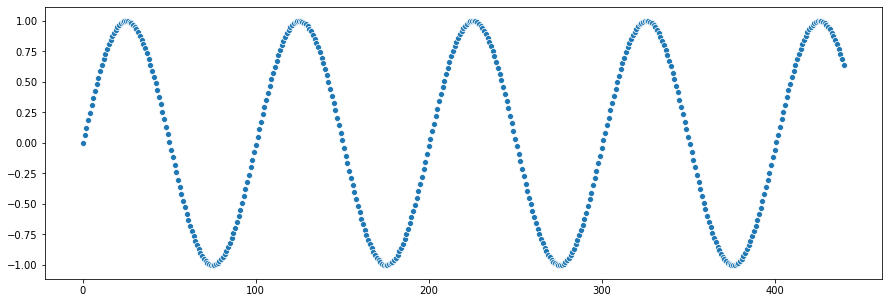

In [32]:
plt.figure(figsize=(15,5))
x = np.arange(fs*duration)
y = np.sin(2*np.pi*x*f/fs)
sns.scatterplot(x,y);

## Note Duration

To find the length in seconds of each beat for any given metronome marking in beats-per-minute (bpm), you would divide 60 (the number of seconds in a minute) by the bpm marking. For instance, if a piece has a metronome marking of crotchet (quarter-note) = 120, each crotchet beat is 0.5 seconds long (60/120).

You can follow this simple rule to find the length of a crotchet whenever the tempo marking shows how many crotchet beats per minute there are. This will usually be for time-signatures with crotchet beats (i.e. with a 4 at the bottom, eg. 4/4, 3/4, 2/4 etc.)

<img src='../resources/notes_to_seconds.jpg'>

## Note Notation

We will note what note will be played and what type of note, 1 for whole, 2 for a half note , 4 for quater note, 8 for an eight note, etc.

Fancy Names:
+ Semibreve (whole note)
+ Minim (half note)
+ Crotchet (quarter note)
+ Quaver (eighth note)
+ Semiquaver (16th note)
+ Demisemiquaver (32nd note)

See https://hellomusictheory.com/learn/types-of-musical-notes/ to see which notes are which.

We need to say what note and how long it should be played. Say we had 4 quater note C's:

<img src='../resources/4_cs.jpg'>

We will notate this as:
```
Note, Duration
C4, 4
C4, 4
C4, 4
C4, 4
```

## Imperial March

<img src='../resources/imperial_march.jpg' width='50%'>

```
Note, Duration
A5, 4
A5, 4
A5, 4
F5, 8
C6, 8
```

## Music with Python

In [21]:
import pyaudio

p = pyaudio.PyAudio()

volume = 0.5     # range [0.0, 1.0]
fs = 44100       # sampling rate, Hz, must be integer
duration = 1.0   # in seconds, may be float
f = 440.0        # sine frequency, Hz, may be float

# generate samples, note conversion to float32 array
samples = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)

# for paFloat32 sample values must be in range [-1.0, 1.0]
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=fs,
                output=True)

# play. May repeat with different volume values (if done interactively)
samples = (volume*np.sin(2*np.pi*np.arange(fs*duration)*f/fs)
           ).astype(np.float32).tobytes()
stream.write(samples)
stream.stop_stream()
stream.close()

p.terminate()


## Generating Samples

In [34]:
def gen_samples(f, duration, fs=44100):
    """
    Function that generates sinusional samples at a frequency f, with a sampling frequency of fs for duration in seconds

    Parameters
    f (float): Frequency to generate
    duration (float): Time in seconds
    fs (float): Sampling frequency - defaults ot 441000 Hz
    """

    samples = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)

    return samples


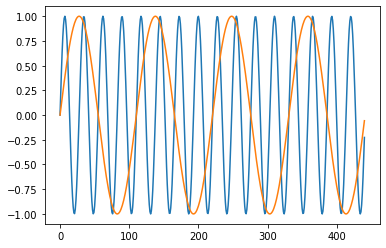

In [40]:
plt.plot(gen_samples(1600, 0.01))
plt.plot(gen_samples(400, 0.01))

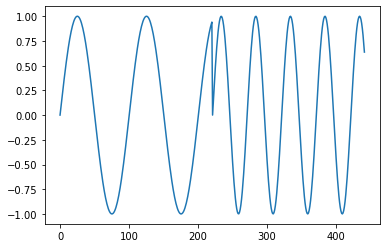

In [42]:
plt.plot(np.concatenate((gen_samples(440, 0.005),
                gen_samples(880, 0.005))))

In [53]:
def play_audio(samples, fs=44100, volume=0.5):
    p = pyaudio.PyAudio()
    
    # for paFloat32 sample values must be in range [-1.0, 1.0]
    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=fs,
                    output=True)

    stream.write(samples)
    stream.stop_stream()
    stream.close()

    p.terminate()

In [54]:
np.concatenate((gen_samples(440, 1), 
                gen_samples(880, 1))).shape

(88200,)

In [55]:
gen_samples(440, 1).shape

(44100,)

## Putting it all together

In [154]:
play_audio(gen_samples(1000, 1))
play_audio(gen_samples(4000, 1))

In [170]:
imperial_march = pd.read_csv('../data/imperial_march.gln')
imperial_march.tail()

,Note,Length
50,Gb5,16
51,Bb4,16
52,Eb5,4
53,D5,8
54,Db5,8


In [171]:
df = imperial_march.merge(notes, on='Note', how='left')

In [180]:
bpm = 30

In [181]:
def length_to_duration(length, bpm):
    """
    Function that converts length to bpm
    
    Assumes that the lenght of a quater note is 4
    """
    return 4*60/bpm*1/length

In [182]:
df['Duration'] = df.Length.apply(lambda x: length_to_duration(x, bpm))

In [183]:
for row in df.iterrows():
    duration = row[1].Duration
    frequency = row[1].Frequency
    play_audio(gen_samples(frequency, duration))